In [2]:
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon
from fiona.crs import from_epsg
%matplotlib inline

In [3]:
os.chdir("/Users/yanghaoming/Desktop/Data_science/PUI2018/HW8_hy1528/")

## 1. Get the school district data
Download link: https://data.cityofnewyork.us/Education/School-Districts/r8nu-ymqj

In [4]:
school=gpd.GeoDataFrame.from_file('School Districts/geo_export_4b7fdc2f-ff59-44b5-81ab-2f97936e7474.shp')

In [5]:
school.head()

,school_dis,shape_area,shape_leng,geometry
0,16.0,4.676362e+07,35848.904605,POLYGON ((-73.93311862859143 40.69579115384632...
1,32.0,5.189850e+07,37251.057847,POLYGON ((-73.91180710069435 40.70343495202662...
2,6.0,9.634170e+07,70447.849084,POLYGON ((-73.92640556921116 40.87762147653734...
3,21.0,2.101962e+08,123855.337856,POLYGON ((-73.96184657346174 40.62757081710622...
4,31.0,1.604472e+09,434471.412859,(POLYGON ((-74.05050806403247 40.5664220341608...


In [6]:
school.crs

{'init': 'epsg:4326'}

## 2. Get the school directory data
Download link: https://data.cityofnewyork.us/Education/2017-DOE-High-School-Directory/s3k6-pzi2

In [7]:
name=pd.read_csv('2017_DOE_High_School_Directory.csv',usecols=['school_name','Latitude','Longitude'])

In [8]:
name.head()

,school_name,Latitude,Longitude
0,Tottenville High School,40.52815,-74.1934
1,Long Island City High School,40.76588,-73.9339
2,William Cullen Bryant High School,40.75707,-73.9112
3,Frank Sinatra School of the Arts High School,40.75610,-73.9252
4,Francis Lewis High School,40.74088,-73.7950


In [9]:
name.school_name=name.school_name.str.upper()

## 3. Get the school SAT result data
Download link: https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4

In [10]:
SAT=pd.read_csv('2012_SAT_Results.csv')

In [11]:
SAT.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


## 4. Merge SAT data with school directory data

In [12]:
merge1=SAT.merge(name, left_on='SCHOOL NAME',right_on='school_name',how='inner')

In [13]:
merge1.drop(merge1[['DBN','school_name']], axis=1,inplace=True)

In [14]:
merge1['geometry']=None
for index, row in merge1.iterrows():
    point=Point(row['Longitude'],row['Latitude'])
    merge1.loc[index,'geometry']=point
merge1.head()

,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,Latitude,Longitude,geometry
0,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,40.71227,-73.9841,POINT (-73.9841 40.71227)
1,EAST SIDE COMMUNITY SCHOOL,70,377,402,370,40.72915,-73.9825,POINT (-73.9825 40.72915)
2,MARTA VALLE HIGH SCHOOL,44,390,433,384,40.72004,-73.9860,POINT (-73.986 40.72004)
3,BARD HIGH SCHOOL EARLY COLLEGE,130,624,604,628,40.71828,-73.9761,POINT (-73.9761 40.71828)
4,FOOD AND FINANCE HIGH SCHOOL,62,409,393,392,40.76547,-73.9927,POINT (-73.9927 40.76547)


## 5. Convert to geoDataFrame

In [15]:
merge1=gpd.GeoDataFrame(merge1,geometry='geometry',crs=from_epsg(4326))

In [16]:
merge1.drop(merge1[['Latitude','Longitude']], axis=1,inplace=True)

In [17]:
merge1=merge1.rename(columns={'Num of SAT Test Takers':'Num','SAT Critical Reading Avg. Score':'CR_score','SAT Math Avg. Score':'Math_score','SAT Writing Avg. Score':'Writing_score'})

In [18]:
merge1.head()

,SCHOOL NAME,Num,CR_score,Math_score,Writing_score,geometry
0,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,POINT (-73.9841 40.71227)
1,EAST SIDE COMMUNITY SCHOOL,70,377,402,370,POINT (-73.9825 40.72915)
2,MARTA VALLE HIGH SCHOOL,44,390,433,384,POINT (-73.986 40.72004)
3,BARD HIGH SCHOOL EARLY COLLEGE,130,624,604,628,POINT (-73.9761 40.71828)
4,FOOD AND FINANCE HIGH SCHOOL,62,409,393,392,POINT (-73.9927 40.76547)


In [19]:
merge1.CR_score=pd.to_numeric(merge1.CR_score,errors='coerce').dropna()
merge1.Num=pd.to_numeric(merge1.Num,errors='coerce').dropna()
merge1.Math_score=pd.to_numeric(merge1.Math_score,errors='coerce').dropna()
merge1.Writing_score=pd.to_numeric(merge1.Writing_score,errors='coerce').dropna()


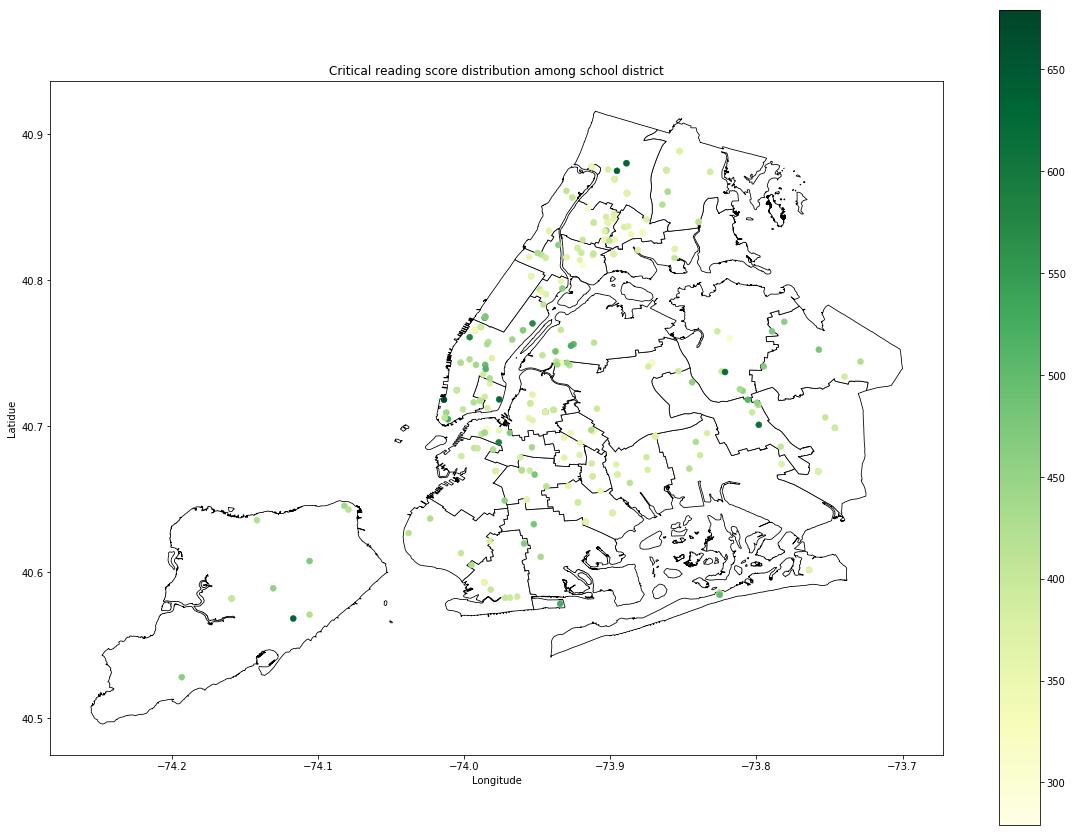

In [30]:
ax=school.plot(color="white", edgecolor="black", lw=0.8,figsize=(20,15))
vmin=merge1.CR_score.min()
vmax=merge1.CR_score.max()
merge1.plot(ax=ax,column='CR_score',cmap="YlGn",lw=0.5,vmin=vmin, vmax=vmax, legend=True)
plt.xlabel('Longitude')
plt.ylabel('Latidue')
plt.title('Critical reading score distribution among school district')
plt.savefig('/Users/yanghaoming/Desktop/Data_science/PUI2018/HW11_hy1528')

## Figure1:
#### The figures shows all the high school mean critical reading score on the school district map. The lighter the color indicate the higher the score. From the map, although it is very difficult, we could identify which school district have higher score in the SAT exam. For example, the school district in Manhattan have the highest mean critical reading score.

In [51]:
def get_district_mean(col):
    school[col]=None
    for index, row in school.iterrows():
        total=merge1['Num'][merge1.geometry.within(row.geometry)].sum()
        percentage_num=merge1['Num'][merge1.geometry.within(row.geometry)]/total
        per_score=merge1[col][merge1.geometry.within(row.geometry)]*percentage_num
        mean_score=per_score.sum()
        school.loc[index,col]=mean_score
    return school

In [52]:
school_CR=get_district_mean('CR_score')
school_math=get_district_mean('Math_score')
school_Write=get_district_mean('Writing_score')

Text(0.5,1,'Critical Reading score rank among school district')

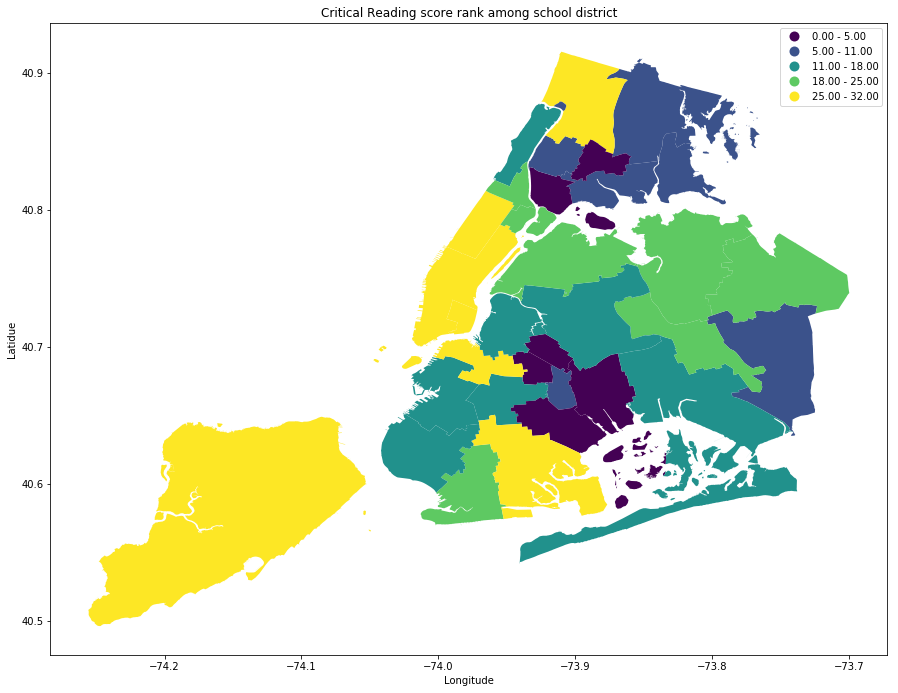

In [53]:
school_CR.plot(column='CR_score',cmap="viridis", lw=0.5,legend=True,figsize=(15,15),scheme="fisher_jenks")
plt.xlabel('Longitude')
plt.ylabel('Latidue')
plt.title('Critical Reading score rank among school district')

## Figure2:
#### The figures shows the rank of mean critical reading score on school district level. The lighter the color indicate the higher the score. From the map,  we could easily identify which school district have higher score in the SAT exam on critical reading part. 

Text(0.5,1,'Math score rank among school district')

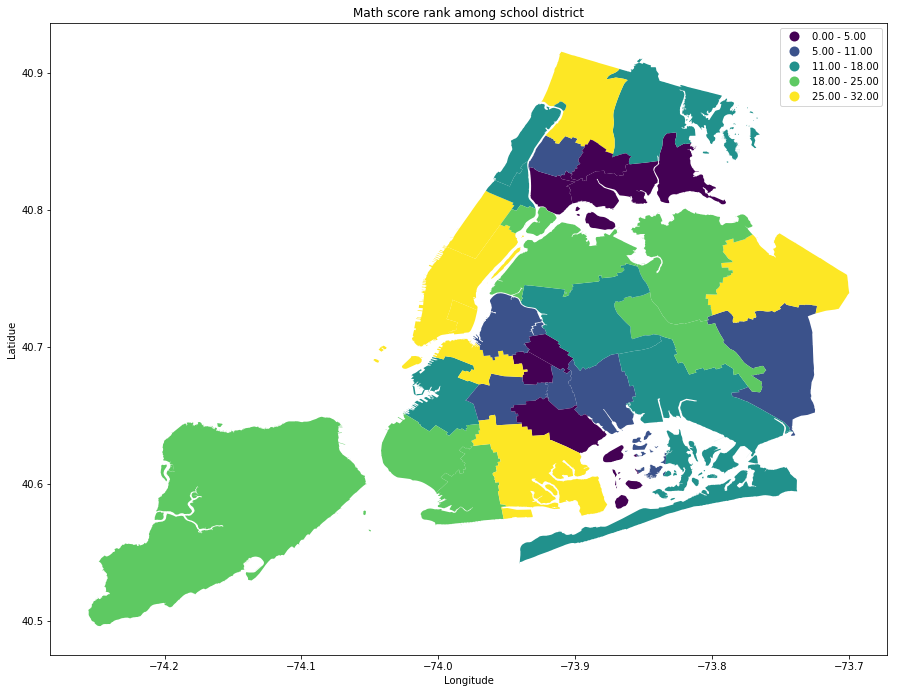

In [54]:
school_CR.plot(column='Math_score',cmap="viridis", lw=0.5,legend=True,figsize=(15,15),scheme="fisher_jenks")
plt.xlabel('Longitude')
plt.ylabel('Latidue')
plt.title('Math score rank among school district')

## Figure3:
#### The figures shows the rank of mean math score on school district level. The lighter the color indicate the higher the score. From the map,  we could easily identify which school district have higher score in the SAT exam on math part. We could find that some district remain high score in both critical reading and math.

Text(0.5,1,'Writing score rank among school district')

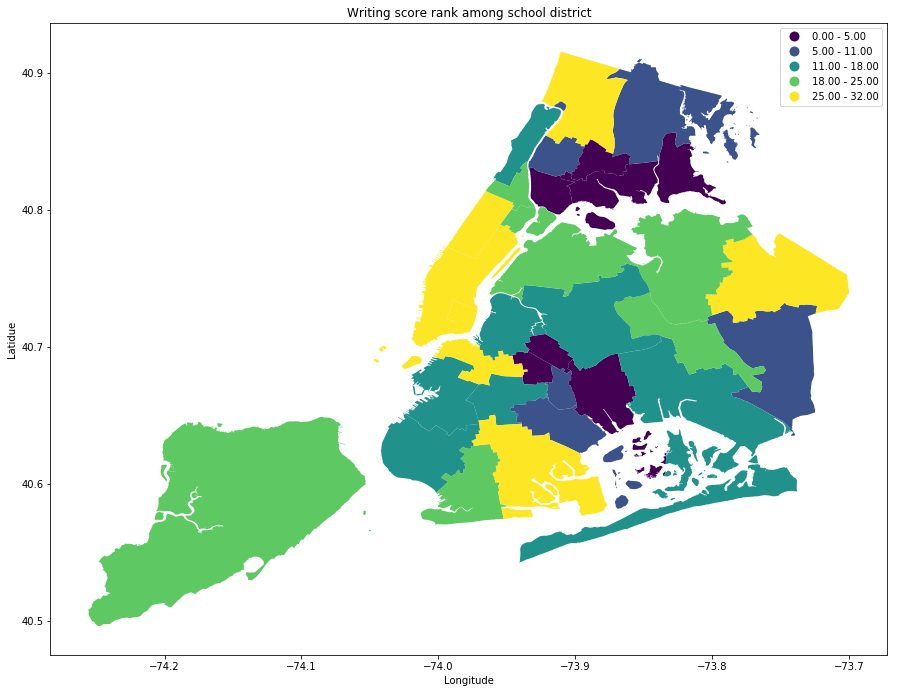

In [55]:
school_CR.plot(column='Writing_score',cmap="viridis", lw=0.5,legend=True,figsize=(15,15),scheme="fisher_jenks")
plt.xlabel('Longitude')
plt.ylabel('Latidue')
plt.title('Writing score rank among school district')

## Figure4:
#### The figures shows the rank of mean writing score on school district level. The lighter the color indicate the higher the score. From the map,  we could easily identify which school district have higher score in the SAT exam on writing part. We could find that some district remain high score in critical reading,math,writing. 

In [56]:
school['total_score']=None
school['total_score']=school_CR['CR_score']+school_math['Math_score']+school_Write['Writing_score']

Text(0.5,1,'total score rank among school district')

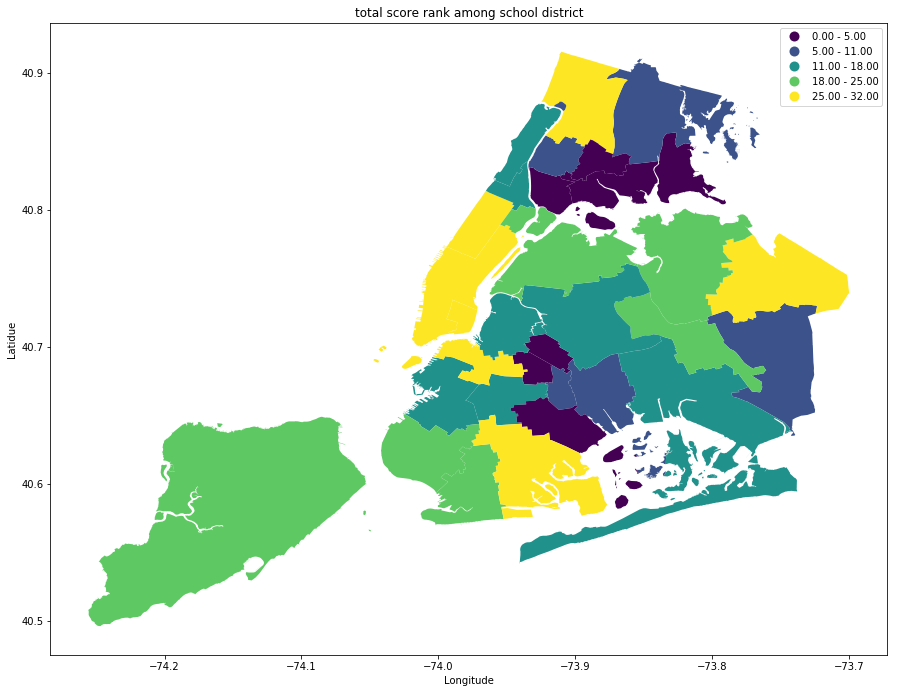

In [57]:
school.plot(column='total_score',cmap="viridis", lw=0.5,legend=True,figsize=(15,15),scheme="fisher_jenks")
plt.xlabel('Longitude')
plt.ylabel('Latidue')
plt.title('total score rank among school district')

## Figure5:
#### The figures shows the rank of mean total score on school district level. The lighter the color indicate the higher the score. From the map,  we could easily identify which school district have higher score in the SAT exam. We could identify the district that produce highest score in SAT exam.